# Import relevant modules and functions

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Surprise (NMF recommender)
from surprise import NMF, Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV

# Sklearn (PCA and clustering)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

# Load and prepare the data

In [2]:
# Data downloaded from https://grouplens.org/datasets/movielens/
df_movies = pd.read_csv('../data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df_ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df_movies.shape, df_ratings.shape

((9742, 3), (100836, 4))

In [5]:
# Merge both dataframes to get one single dataframe
df_full = pd.merge(left=df_ratings, right=df_movies, how='left', on='movieId')
df_full.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [6]:
# Create mask for filtering by defining how many people 'must have watched' a movie (min)
threshold = 20
mask = pd.merge(df_full, pd.DataFrame(df_full.groupby('movieId')['userId'].count()>threshold), 
                how='left', on='movieId').iloc[:,-1]
mask

0          True
1          True
2          True
3          True
4          True
          ...  
100831    False
100832    False
100833    False
100834     True
100835    False
Name: userId_y, Length: 100836, dtype: bool

In [7]:
# Create new dataframe by filtering out movies which have been watched by less than the defined number of people
df = df_full[mask]
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [8]:
df.title.unique().shape

(1235,)

# Popular movie recommender

In [9]:
# Get most popular movies
df_movie_ratings = pd.DataFrame(df.groupby('title')['rating'].mean().sort_values(ascending=False)).reset_index()
df_movie_ratings.head()

,title,rating
0,"Shawshank Redemption, The (1994)",4.429022
1,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.333333
2,"Philadelphia Story, The (1940)",4.310345
3,Lawrence of Arabia (1962),4.300000
4,In the Name of the Father (1993),4.300000


In [10]:
# Determine 'most popular movies not seen yet' for user, e.g. here user with userId = 99
watched_movies = list(df[df['userId']==99]['title'])
mask = df_movie_ratings['title'].apply(lambda x: x not in watched_movies)
df_movie_ratings[mask].head()

,title,rating
1,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.333333
2,"Philadelphia Story, The (1940)",4.310345
3,Lawrence of Arabia (1962),4.300000
4,In the Name of the Father (1993),4.300000
5,Hoop Dreams (1994),4.293103


# NMF recommender

## Prepare data

In [11]:
# Prepare dataframe
df_nmf = df[['userId', 'movieId', 'rating']]
df_nmf

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100803,610,148626,4.0
100808,610,152081,4.0
100829,610,164179,5.0
100830,610,166528,4.0


In [12]:
df_nmf['rating'].min(), df_nmf['rating'].max()

(0.5, 5.0)

In [13]:
# Define the scale of the ratings, needed to set boundaries for the output
reader = Reader(rating_scale=(0, 5))

In [14]:
# Load the data
data = Dataset.load_from_df(df_nmf, reader)

In [15]:
# Define the whole dataset as trainset
trainset = data.build_full_trainset() 

## Find optimal number of hidden features

In [16]:
param_grid = {
    'n_factors' : [5, 15, 50],
    'n_epochs' : [50, 100, 150, 200],    
}

In [17]:
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=1)

In [18]:
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


In [19]:
pd.DataFrame(gs.cv_results)[['params', 'mean_test_rmse', 'rank_test_rmse', 'mean_fit_time']].sort_values('rank_test_rmse')

,params,mean_test_rmse,rank_test_rmse,mean_fit_time
11,"{'n_factors': 50, 'n_epochs': 200}",0.838115,1,21.501723
10,"{'n_factors': 50, 'n_epochs': 150}",0.838829,2,18.130880
9,"{'n_factors': 50, 'n_epochs': 100}",0.840029,3,11.653924
3,"{'n_factors': 5, 'n_epochs': 200}",0.847987,4,6.069218
2,"{'n_factors': 5, 'n_epochs': 150}",0.854625,5,4.540476
6,"{'n_factors': 15, 'n_epochs': 150}",0.857896,6,7.324359
7,"{'n_factors': 15, 'n_epochs': 200}",0.859252,7,10.118707
5,"{'n_factors': 15, 'n_epochs': 100}",0.864436,8,4.835415
1,"{'n_factors': 5, 'n_epochs': 100}",0.865676,9,2.981614
4,"{'n_factors': 15, 'n_epochs': 50}",0.868939,10,2.392875


In [20]:
n_factors = 5
n_epochs = 200

## Create NMF model

In [21]:
# Create the model, k = number of hidden features
model = NMF(n_factors=n_factors, n_epochs=n_epochs) 

In [22]:
# Fit the model
model.fit(trainset)

In [23]:
# Calculate P and Q...
Q = model.qi 
P = model.pu
P.shape, Q.shape

((610, 5), (1235, 5))

In [24]:
# ...to get full (reconstructed) matrix
np.round(np.dot(P, Q.T), 1)

array([[4.6, 3.7, 4.5, ..., 3. , 3.3, 3.5],
       [3.5, 3.4, 3.7, ..., 1.9, 3.4, 2.8],
       [2. , 2.1, 2.1, ..., 0.9, 1. , 1.9],
       ...,
       [3.1, 2.9, 3.8, ..., 2.1, 2.9, 2.7],
       [3.4, 3.1, 3.6, ..., 1.9, 2.6, 2.7],
       [4. , 3.4, 4.2, ..., 2.6, 2.8, 3.2]])

In [25]:
# Predict a value for a specific user and movie...
model.predict(1,1)

Prediction(uid=1, iid=1, r_ui=None, est=4.639819167303868, details={'was_impossible': False})

In [26]:
#...and compare it with existing values
df_nmf[(df_nmf['userId']==1) & (df_nmf['movieId']==1)]

,userId,movieId,rating
0,1,1,4.0


## Derive recommendations for a new user

In [27]:
user = 'new_user'
movie_ratings = {
    'Toy Story (1995)' : 2,
    'Batman Begins (2005)' : 5,
    'Inception (2010)' : 4,
    'Heat (1995)' : 3,
}

In [28]:
# Create {movieId : title} and {title : movieId} dictionaries
movieId_dict = {}
for idx, movieId, title in df[['movieId', 'title']].itertuples():
    movieId_dict[movieId] = title

title_dict = {value:key for key, value in movieId_dict.items()}

In [29]:
# Convert movie rratings into movie IDs
movie_ratings = {title_dict[title]:rating for title, rating in movie_ratings.items()}
movie_ratings

{1: 2, 33794: 5, 79132: 4, 6: 3}

In [30]:
# Create dataframe for new user
df_new_usr = pd.DataFrame.from_dict(movie_ratings, orient='index')
df_new_usr['userId']=user
df_new_usr = df_new_usr.reset_index().rename(columns={'index':'movieId', 0:'rating'})
df_new_usr = df_new_usr[['userId', 'movieId', 'rating']]
df_new_usr

,userId,movieId,rating
0,new_user,1,2
1,new_user,33794,5
2,new_user,79132,4
3,new_user,6,3


In [31]:
# Concat dataframes (i.e. create one single / new dataset)
df_nmf_new = pd.concat([df_nmf, df_new_usr], ignore_index=True)
df_nmf_new.tail(10)

,userId,movieId,rating
66652,610,139385,4.5
66653,610,148626,4.0
66654,610,152081,4.0
66655,610,164179,5.0
66656,610,166528,4.0
66657,610,168252,5.0
66658,new_user,1,2.0
66659,new_user,33794,5.0
66660,new_user,79132,4.0
66661,new_user,6,3.0


In [32]:
# Load the data
data = Dataset.load_from_df(df_nmf_new, reader)

In [33]:
# Define the whole dataset as trainset
trainset = data.build_full_trainset() 

In [34]:
# Create the model, k = number of hidden features
model = NMF(n_factors=n_factors, n_epochs=n_epochs) 

In [35]:
# Fit the model
model.fit(trainset)

In [36]:
# Generate test_data
data_all_users = trainset.build_anti_testset()
test_data = [set for set in data_all_users if set[0] == 'new_user']

In [37]:
# Get predictions on test dataset
test_results = model.test(test_data)

In [38]:
# Save results in a dataframe
df_test_results = pd.DataFrame(np.array(test_results)[:,(1,3)], columns=['movieId', 'prediction'])
df_test_results['userId'] = user
df_test_results = df_test_results[['userId', 'movieId', 'prediction']]
df_test_results

,userId,movieId,prediction
0,new_user,3,2.954531
1,new_user,47,3.760455
2,new_user,50,3.475827
3,new_user,70,3.245685
4,new_user,101,2.457442
...,...,...,...
1226,new_user,1958,4.150027
1227,new_user,3979,2.251679
1228,new_user,4247,1.6858
1229,new_user,2986,2.962147


In [39]:
# Generate final result
df_test_results['title'] = df_test_results['movieId'].apply(lambda x: movieId_dict[x])
topX = df_test_results.sort_values('prediction', ascending=False)['title'].head(20)
topX

1057                                       Ben-Hur (1959)
475                                            Saw (2004)
646                       Sex, Lies, and Videotape (1989)
522                              Pride & Prejudice (2005)
656                            Killing Fields, The (1984)
842                                         Scream (1996)
774     Girl with the Dragon Tattoo, The (Män som hata...
492         Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
195                                       Whiplash (2014)
252                  Bridge on the River Kwai, The (1957)
93                                           Rocky (1976)
282                                      Airplane! (1980)
1024                                        Munich (2005)
1094                            Lawrence of Arabia (1962)
47                                        Swingers (1996)
1085                         Thank You for Smoking (2006)
1034                   Madness of King George, The (1994)
239           

In [40]:
# Generate final result
df_test_results['title'] = df_test_results['movieId'].apply(lambda x: movieId_dict[x])
topX = df_test_results.sort_values('prediction', ascending=False)['title'].head(20)
topX

1057                                       Ben-Hur (1959)
475                                            Saw (2004)
646                       Sex, Lies, and Videotape (1989)
522                              Pride & Prejudice (2005)
656                            Killing Fields, The (1984)
842                                         Scream (1996)
774     Girl with the Dragon Tattoo, The (Män som hata...
492         Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
195                                       Whiplash (2014)
252                  Bridge on the River Kwai, The (1957)
93                                           Rocky (1976)
282                                      Airplane! (1980)
1024                                        Munich (2005)
1094                            Lawrence of Arabia (1962)
47                                        Swingers (1996)
1085                         Thank You for Smoking (2006)
1034                   Madness of King George, The (1994)
239           

# Movie clustering using hidden features

## Conduct PCA

In [41]:
# Get Q matrix from model (contains hidenn features)
Q = model.qi
Q.shape

(1235, 5)

In [42]:
# Data on which the PCA-transformation is calculated should be normalized, meaning in this case: 
# zero mean & unit variance
scaler = StandardScaler()
Q_nrm = scaler.fit_transform(Q)

In [43]:
# Average needs to be zero for PCA to work
#mean = Q.mean(axis=0)
#demeaned = Q - mean

pca = PCA(n_components=3)
pca.fit(Q_nrm)

#print(pca.components_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.30739543 0.24169625 0.2285674 ]
0.7776590718941297


In [44]:
# Transform Q_nrm (onto pca components)
Q_pca = pca.transform(Q_nrm)
Q_pca.shape

(1235, 3)

## Perform K-means

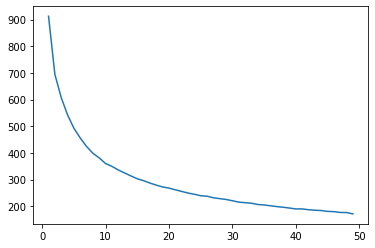

In [45]:
# Plot inertia curve to see what the number of clusters should be like
inertia = []
for i in range(1,50):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(Q)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 50), inertia)

In [46]:
# Maximum silhoutte for k = 10!!!
kmeans = KMeans(n_clusters=10)
kmeans.fit(Q_pca)
silhouette_score(Q_pca, kmeans.labels_)

0.23770707570266533

In [47]:
# Define dataframe with movie titles and cluster labels
movie_list = []
for iid in range(Q_pca.shape[0]):
    r_id = trainset.to_raw_iid(iid)
    title = movieId_dict[r_id]
    movie_list.append(title)

df_clusters = pd.DataFrame({'movies' : movie_list, 'labels' : kmeans.labels_})
df_clusters.groupby('labels').count()

,movies
labels,
0,149
1,138
2,96
3,95
4,132
5,95
6,104
7,155
8,159


In [48]:
# Inspect cluster 1 - any similarities between movies??
df_clusters[df_clusters['labels']==1].head(10)

,movies,labels
0,Toy Story (1995),1
1,Grumpier Old Men (1995),1
7,Braveheart (1995),1
14,Star Wars: Episode IV - A New Hope (1977),1
23,"Fugitive, The (1993)",1
24,Jurassic Park (1993),1
28,"Three Musketeers, The (1993)",1
38,"Rock, The (1996)",1
43,"Sword in the Stone, The (1963)",1
47,That Thing You Do! (1996),1


In [49]:
# Taking into account mean ratings of the movies
mean_rating = df.groupby('title')[['rating']].mean().sort_values('rating', ascending=False)
mean_rating_dict = {}
for title, rating in mean_rating.itertuples():
    mean_rating_dict[title] = rating

In [50]:
selected_cluster = 1
df_clusters['mean_rating'] = df_clusters['movies'].apply(lambda x: mean_rating_dict[x])
df_clusters[df_clusters['labels']==selected_cluster].sort_values('mean_rating', ascending=False).head(10)

,movies,labels,mean_rating
186,"Dark Knight, The (2008)",1,4.238255
59,"Princess Bride, The (1987)",1,4.232394
14,Star Wars: Episode IV - A New Hope (1977),1,4.231076
58,Star Wars: Episode V - The Empire Strikes Back...,1,4.215640
60,Raiders of the Lost Ark (Indiana Jones and the...,1,4.207500
675,Toy Story 3 (2010),1,4.109091
688,Howl's Moving Castle (Hauru no ugoku shiro) (2...,1,4.075000
1042,"Femme Nikita, La (Nikita) (1990)",1,4.071429
141,"Iron Giant, The (1999)",1,4.051282
77,Indiana Jones and the Last Crusade (1989),1,4.046429


## Plot 3D scatter plot

In [51]:
# Add pca-coordinates to dataframe for plotting
df_clusters[['pca_1', 'pca_2', 'pca_3']] = Q_pca
df_clusters

,movies,labels,mean_rating,pca_1,pca_2,pca_3
0,Toy Story (1995),1,3.920930,0.649224,0.042402,-0.597296
1,Grumpier Old Men (1995),1,3.259615,0.557808,0.051746,-0.452215
2,Heat (1995),4,3.946078,-0.703586,-0.897363,0.458368
3,Seven (a.k.a. Se7en) (1995),8,3.975369,-1.169874,-1.035678,0.297801
4,"Usual Suspects, The (1995)",8,4.237745,-1.152744,-0.282037,0.808497
...,...,...,...,...,...,...
1230,Terms of Endearment (1983),8,3.795455,-1.489270,-0.688834,2.103763
1231,Little Nicky (2000),2,2.500000,-1.519806,-0.951772,-0.694550
1232,Joe Dirt (2001),0,2.380952,-0.036224,0.967353,0.935782
1233,RoboCop 2 (1990),7,2.640000,1.881685,-0.299642,-0.211729


In [77]:
import plotly.graph_objects as go

PLOT = go.Figure()

# Plott items in a loop for every cluster
for C in list(df_clusters['labels'].unique()):
    
    PLOT.add_trace(go.Scatter3d(x = df_clusters[df_clusters['labels'] == C]['pca_1'],
                                y = df_clusters[df_clusters['labels'] == C]['pca_2'],
                                z = df_clusters[df_clusters['labels'] == C]['pca_3'],
                                hovertemplate='<b>%{text} </b><extra></extra>',
                                text = [title for title in df_clusters[df_clusters['labels'] == C]['movies']],
                                mode = 'markers', marker_size = 8, marker_line_width = 1, 
                                name = 'Cluster ' + str(C)))

# Add formatting (e.g. labels for axes)
PLOT.update_layout(width = 600, height = 600, autosize = True, showlegend = True,
           scene = dict(xaxis=dict(title = 'pca_1', titlefont_color = 'black'),
                        yaxis=dict(title = 'pca_2', titlefont_color = 'black'),
                        zaxis=dict(title = 'pca_3', titlefont_color = 'black')),
           font = dict(family = "Gilroy", color  = 'black', size = 12))

# My sandbox (to be deleted)

## DBSCAN

In [53]:
# WIP - does not work yet

In [54]:
from sklearn.cluster import DBSCAN

In [55]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=2)
neighbors = nn.fit(Q_pca)
distances, indices = neighbors.kneighbors(Q_pca)

In [56]:
indices

array([[   0,    1],
       [   1,    0],
       [   2, 1068],
       ...,
       [1232,   12],
       [1233,  380],
       [1234,  436]])

In [57]:
distances = np.sort(distances, axis=0)[:,1]

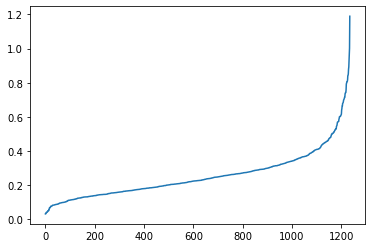

In [58]:
plt.plot(distances)

In [59]:
# Define the optimal eps based on above graph
eps_opt = 0.4

In [60]:
dbscan = DBSCAN(eps=eps_opt, min_samples=15)
labels = dbscan.fit_predict(Q_pca)
pd.DataFrame(labels).groupby(0)[0].count()

0
-1    1064
 0      42
 1      18
 2      55
 3      16
 4      24
 5      16
Name: 0, dtype: int64

## Tests for deployment

In [61]:
movies_path = '~/Documents/spiced_projects/fenugreek-student-code/week10/data/ml-latest-small/movies.csv'
ratings_path = '~/Documents/spiced_projects/fenugreek-student-code/week10/data/ml-latest-small/ratings.csv'

In [62]:
def load_data():
    # Load the data
    df_movies = pd.read_csv(movies_path)
    df_ratings = pd.read_csv(ratings_path)
    
    # Merge dataframes
    df_full = pd.merge(left=df_ratings, right=df_movies, how='left', on='movieId')

    # Filter out movies with count below 20
    mask = pd.merge(df_full, pd.DataFrame(df_full.groupby('movieId')['userId'].count()>20), 
                how='left', on='movieId').iloc[:,-1]
    df = df_full[mask]

    # Return dataframe
    return df

In [63]:
def create_dicts(df):
    """
    Create dictionary to enable conversion between movieIds and titles. Needs
    a dataframe with movieId and title columns as input (should be exhaustive).
    """
    # Create dictionary movieId -> title
    movieId_dict = {}
    for idx, movieId, title in df[['movieId', 'title']].itertuples():
        movieId_dict[movieId] = title

    # Create dictionary title -> movieId
    title_dict = {value:key for key, value in movieId_dict.items()}
        
    return movieId_dict, title_dict

In [64]:
def nmf_recommender(movie_ratings=None):
    """
    Recommender based on negative matrix factorization 
    (utilizing the surprise package)
    """
    # load data
    df = load_data()
    
    # load dictionaries
    movieId_dict, title_dict = create_dicts(df)

    # Convert movie ratings into movie IDs
    if movie_ratings == None:
        movie_ratings = {
        'Toy Story (1995)' : 4,
        'From Dusk Till Dawn (1996)' : 3,
        'Pulp Fiction (1994)' : 5,
        'Some Like It Hot (1959)' : 2,
        'Lawrence of Arabia (1962)' : 3,
        'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)' : 4,
        'Roman Holiday (1953)' : 3,
        'Wallace & Gromit: The Best of Aardman Animation (1996)' : 1
    }
    movie_ratings = {title_dict[title]:rating for title, rating in movie_ratings.items()}

    # Create dataframe for new user
    df_new_usr = pd.DataFrame.from_dict(movie_ratings, orient='index')
    df_new_usr['userId']='new_user'
    df_new_usr = df_new_usr.reset_index().rename(columns={'index':'movieId', 0:'rating'})
    df_new_usr = df_new_usr[['userId', 'movieId', 'rating']]

    # Concat dataframes (i.e. create one single / new dataset)
    df_nmf = df[['userId', 'movieId', 'rating']]
    df_nmf = pd.concat([df_nmf, df_new_usr], ignore_index=True)
    
    # Load the data
    reader = Reader(rating_scale=(0, 5)) # Define the scale of the ratings
    data = Dataset.load_from_df(df_nmf, reader)
    
    # Define the whole dataset as trainset
    trainset = data.build_full_trainset() 

    # Create the model, n_features and n_epochs optimized via grid search
    n_factors = 5 
    n_epochs = 200
    model = NMF(n_factors=n_factors, n_epochs=n_epochs) 

    # Fit the model
    model.fit(trainset)

    # Generate test_data
    data_all_users = trainset.build_anti_testset()
    test_data = [set for set in data_all_users if set[0] == 'new_user']
        
    # Get predictions on test dataset
    test_results = model.test(test_data)

    # Save results in a dataframe
    df_test_results = pd.DataFrame(np.array(test_results)[:,(1,3)], columns=['movieId', 'prediction'])
    df_test_results['userId'] = 'new_user'
    df_test_results = df_test_results[['userId', 'movieId', 'prediction']]
    df_test_results

    # Generate final result
    df_test_results['title'] = df_test_results['movieId'].apply(lambda x: movieId_dict[x])
    top5 = list(df_test_results.sort_values('prediction')['title'].head(5))

    return top5

In [65]:
nmf_recommender()

['Anaconda (1997)',
 'Richie Rich (1994)',
 "Charlie's Angels: Full Throttle (2003)",
 'Specialist, The (1994)',
 'Bring It On (2000)']

In [66]:
# Idea use dictionary to save results and create histogram?